## Middleware part

In [7]:
mw=1
path_to_experiment=path_to_experiment="/home/skotti/data_from_cloud/long_data/experiment_7/fourth_copy/"
path_to_logs = "/home/skotti/data_from_cloud/long_data/experiment_7/fourth_copy/middleware1_logs/"

mw_log = open(path_to_experiment+"mw_"+str(mw)+".log","r")
lines = mw_log.readlines()

def is_zero(line):
    parts = line.split(" ")
    if (parts[1] == '0' and parts[2] == '0' and parts[3] == '0' and parts[4] == '0' and parts[5] == '0' and
        parts[6] == '0' and parts[7] == '0' and parts[8] == '0' and parts[9] == '0' and parts[10] == '0'):
        return True
    return False

def check_following_lines(i):
    all_zero = True
    
    n = 0
    for j in range(64):
        n = j
        parts = lines[i+j].split(" ")
        if parts[0] == str(j) and is_zero(lines[i+j]):
            continue
        elif j == 8 or j == 32:
            break
        else:
            all_zero = False
            break
        
    return all_zero, n

new_experiment_positions=[]
new_experiment_positions_end=[]
invalidated_experiments=[]

i = 0
while i < len(lines):
    parts = lines[i].split(" ")
    if is_zero(lines[i]) or lines[i].startswith("DEBUG ethz.StatPrinter") or lines[i].startswith("SIGTERM call"):
        i += 1
        continue
    new_experiment_positions.append(i)
    while True:
        if not is_zero(lines[i]):
            i += 1
        elif is_zero(lines[i]):
            condition, nlines = check_following_lines(i)
            if (condition):
                break
            else:
                print("line numer="+str(i))
                print("condition not ok")
                i+=1
                continue
    new_experiment_positions_end.append(i)

for i in range(len(new_experiment_positions)):
    for j in range(new_experiment_positions[i], new_experiment_positions_end[i]):
        if lines[j].startswith("ERROR"):
            print("Error in line="+str(j))
            print("Invalidate experiment="+str(i))
            invalidated_experiments.append(i)
        elif lines[j].startswith("SIGTERM"):
            print("Sigterm reported in "+ str(i)+".Check the data")
            
for i in range(len(new_experiment_positions)):
    if i not in invalidated_experiments:
        f = open(path_to_logs+"log_"+str(i)+".log", "w")
        for j in range(new_experiment_positions[i], new_experiment_positions_end[i]):
            if (lines[j][0].isdigit()):
                f.write(lines[j])
        f.close()

In [6]:
#### v1
#ex1
#log1 log2 log3 log4 |w1|
#log5 log6 log7 log8 |w2|
#log9 log10 log11 log12 |w3|
#
#log13 log14 log15 log16 |w1|
#log17 log18 log19 log20 |w2|
#log21 log22 log23 log24 |w3|
#
#log25 log26 log27 log28 |w1|
#log29 log30 log31 log32 |w2|
#log33 log34 log35 log36 |w3|
#
#log37 log38 log39 log40 |w1|
#log41 log42 log43 log44 |w2|5534
#log45 log46 log47 log48 |w3|

logs_per_experiment = 36
path_to_logs = "/home/skotti/data_from_cloud/long_data/experiment_7/fourth_copy/middleware1_logs/"

value_sizes = [64, 256, 512, 1024]
client_numbers = [4, 8, 16, 32]
workers = [8, 32, 64]
repetitions = 3
memtier_instances = 3
nServers = 1
experiments = len(workers) * len(value_sizes) * len(client_numbers) * repetitions


import csv
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean

data=[]
k = 72
l = 0
for v in value_sizes:
    print("k="+str(k))
    for w in workers:
        for client in client_numbers:
            for rep in range(repetitions):
                data.append(pd.read_csv(path_to_logs+"log_"+str(k)+".log", header=None, delimiter=' '))
                for j in range(w):
                    d = data[l].index[data[l][0] == j].tolist()
                    data[l] = data[l].drop([d[0]])
                    data[l] = data[l].drop([d[len(d)-1]])
                k += 1
                l += 1
    k += logs_per_experiment * 3
        
global_data_5 = pd.DataFrame(columns=['Worker threads',
                                    'Value size',
                                    'Client number',
                                    'Repetition',
                                    'Worker thread',
                                    'Time1',
                                    'Time2',
                                    'Time3',
                                    'Time4',
                                    'Time5',
                                    'Queue size',
                                    'Left queue',
                                    'Successful',
                                    'Per server1',
                                    'Per server2',
                                    'Per server3',
                                    'Duration'])

print("Start adding data to global table")
k = 0
m = 0
for value_size in value_sizes:
    for w in workers:
        for n in client_numbers:
            for rep in range(repetitions):
                print("m="+str(m))
                for d in range (len(data[m])):
                    if nServers == 1:
                        newline = [w, value_size, n, rep, 
                             data[m].iloc[d, 0], 
                             data[m].iloc[d, 1],
                             data[m].iloc[d, 2], 
                             data[m].iloc[d, 3], 
                             data[m].iloc[d, 4], 
                             data[m].iloc[d, 5],
                             data[m].iloc[d, 6],
                             data[m].iloc[d, 7], 
                             data[m].iloc[d, 8],
                             data[m].iloc[d, 9], 0, 0, 5000]
                    elif nServers == 3:
                        newline = [w, value_size, n, rep, 
                             data[m].iloc[d, 0], 
                             data[m].iloc[d, 1],
                             data[m].iloc[d, 2], 
                             data[m].iloc[d, 3], 
                             data[m].iloc[d, 4], 
                             data[m].iloc[d, 5],
                             data[k].iloc[d, 6],
                             data[m].iloc[d, 7], 
                             data[m].iloc[d, 8], 
                             data[m].iloc[d, 9], 
                             data[m].iloc[d, 10],
                             data[m].iloc[d, 11], 5000]
                    global_data_5.loc[k] = newline
                    k += 1
                m += 1    


k=72
k=216
k=360


FileNotFoundError: File b'/home/skotti/data_from_cloud/long_data/experiment_7/fourth_copy/log_360.log' does not exist

Start drawing graphs


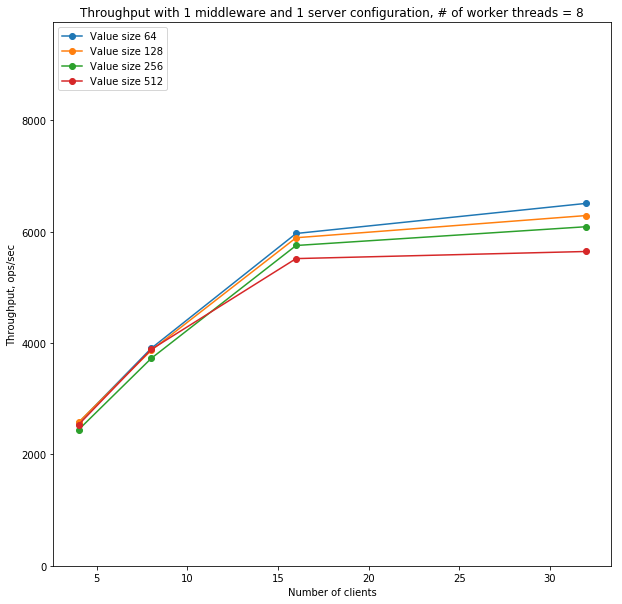

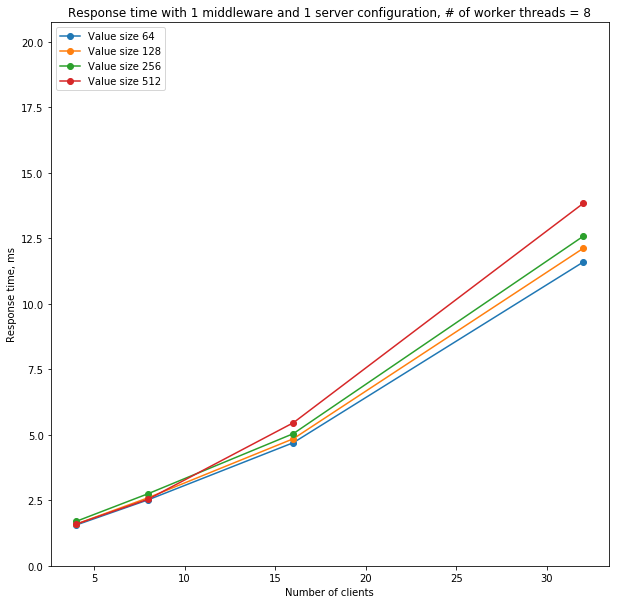

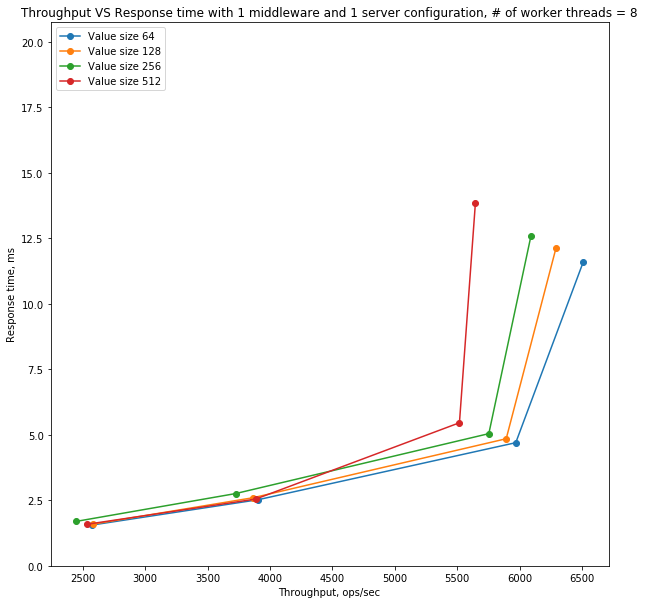

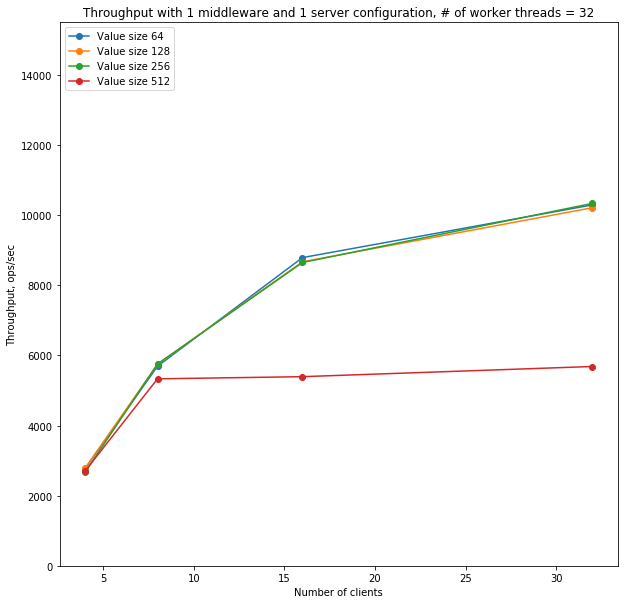

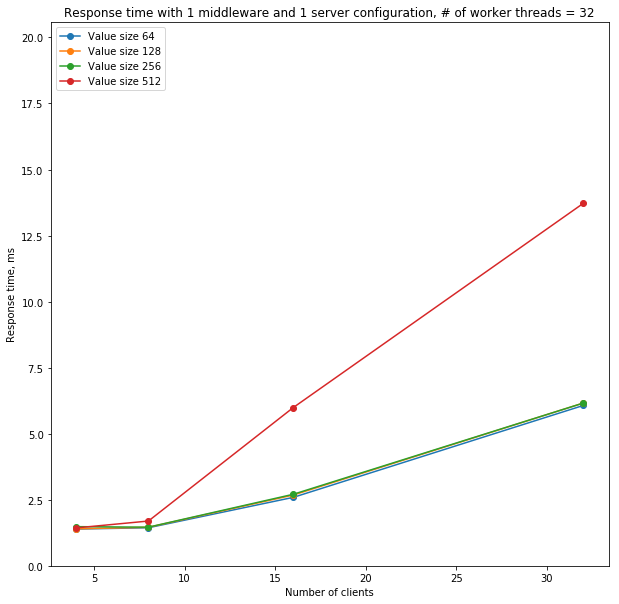

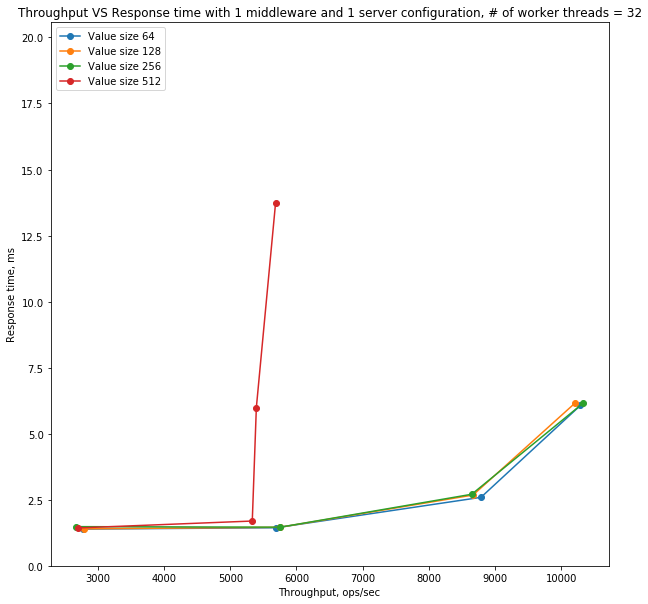

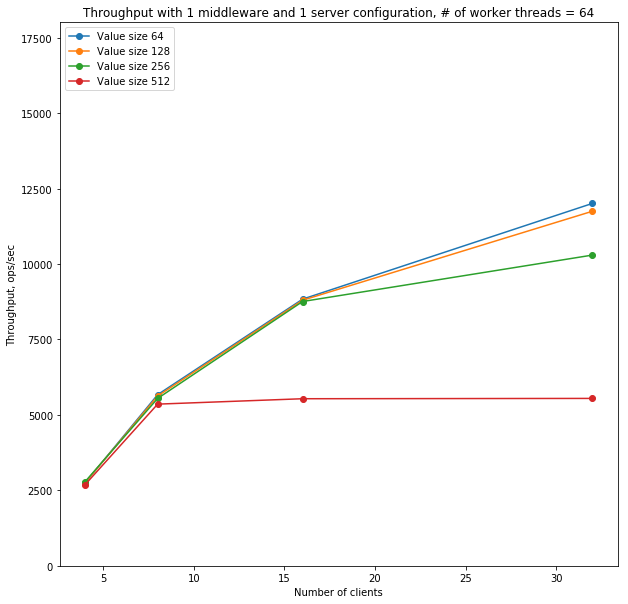

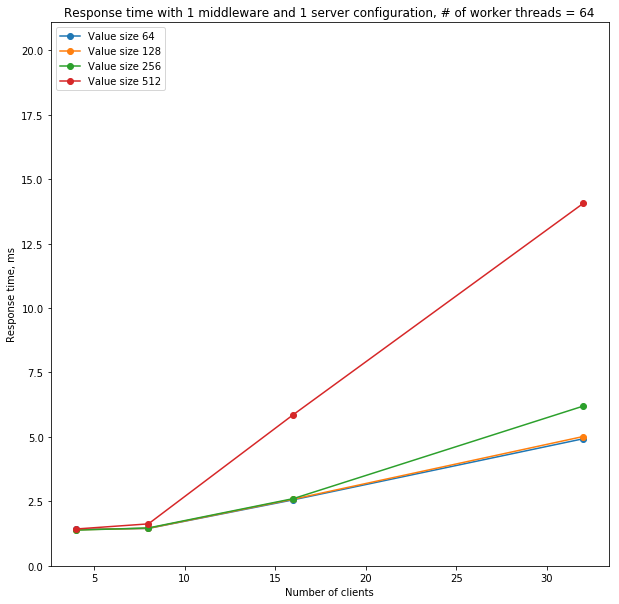

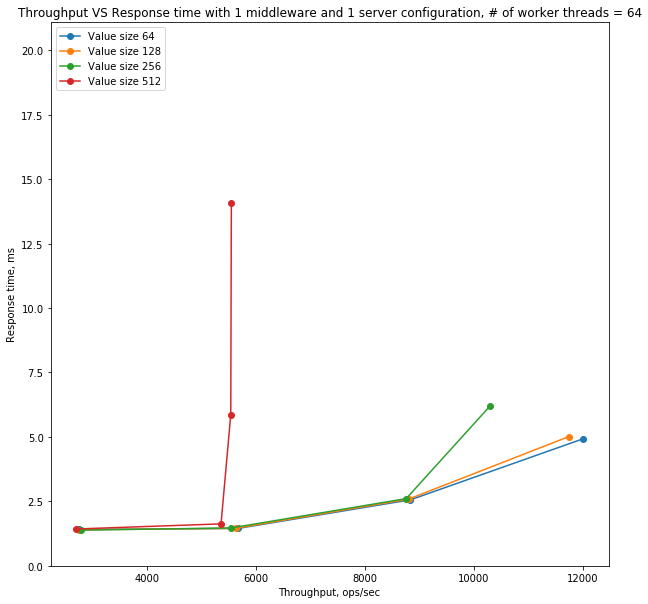

In [4]:
print("Start drawing graphs")
prefix="/home/skotti/asl-project-2019-ruzhanskaia/report_src/part5_mid_mid1_"
for w in workers:
    TR_overall = []
    RT_overall = []
    QT_overall = []
    ST_overall = []
    QS_overall = []
    PT_overall = []
    for value_size in value_sizes:
        TR = []
        RT = []
        QT = []
        ST = []
        QS = []
        PT = []
        TR_error = []
        RT_error = []
        X_axis = client_numbers
        for client_number in client_numbers:
            subset = global_data_5[(global_data_5['Worker threads'] == w) &
                                 (global_data_5['Value size'] == value_size) & 
                                 (global_data_5['Client number'] == client_number)]
            
            # for graphs
            groupped0 = subset.groupby(['Repetition']).sum()
            groupped1 = groupped0[[ 'Time5', 'Successful']].mean()
            RT.append(groupped1['Time5'] / groupped1['Successful'] / 1000000.0)
            
            groupped2 = subset.groupby(['Repetition', 'Worker thread']).sum()[['Successful', 'Duration']]
            groupped3 = groupped2['Successful'] / groupped2['Duration'] * 1000.0
            TR.append(groupped3.groupby(['Repetition']).sum().mean())
            
            '''groupped = subset.groupby(['Repetition']).sum()
            TR_std = np.std(groupped['TR'].values)
            TR_error.append(TR_std)
            TR.append(float(groupped.mean()['TR']))
            groupped1 = subset.groupby(['Repetition']).sum()
            groupped2 = groupped1['Total time']/groupped1['Total ops']
            RT.append(float(groupped2.mean()))
            RT_std = np.std(groupped2.values)
            RT_error.append(RT_std)'''
            
            # for formula checks
            # queue average time for all threads
            groupped4 = subset.groupby(['Repetition']).sum()
            groupped5 = groupped4[[ 'Time1', 'Successful']].mean()
            QT.append(groupped5['Time1'] / groupped5['Successful'] / 1000000.0)
            
            # average service time
            groupped6 = subset.groupby(['Repetition']).sum()
            groupped7 = groupped6[['Time3', 'Successful']].mean()
            ST.append(groupped7['Time3'] / groupped7['Successful'] / 1000000.0)
            
            # average process time
            groupped13 = subset.groupby(['Repetition']).sum()
            groupped14 = groupped13[['Time4', 'Successful']].mean()
            PT.append(groupped14['Time4'] / groupped14['Successful'] / 1000000.0)
            
            # average queue size
            groupped8 = subset.groupby(['Repetition']).sum()
            groupped9 = groupped8[['Queue size', 'Successful']].mean()
            QS.append(groupped9['Queue size'] / groupped9['Successful'])
            
            # TR per worker
            #groupped10 = subset.groupby(['Repetition', 'Worker thread']).sum()[['Successful', 'Duration']]
            #groupped11 = groupped10['Successful'] / groupped10['Duration'] * 1000.0    
            #groupped12 = groupped11.groupby(['Repetition']).mean().mean()
            #print(groupped12)
        TR_overall.append(TR)
        RT_overall.append(RT)
        QT_overall.append(QT)
        ST_overall.append(ST)
        QS_overall.append(QS)
        PT_overall.append(PT)
        
    plt.figure(figsize=(10, 10))
    plt.title("Throughput with 1 middleware and 1 server configuration, # of worker threads = "+str(w))
    max1 = 0
    for i in range(len(TR_overall)):
        plt.plot(X_axis, TR_overall[i], '-o',
                label="Value size "+str(value_sizes[i]))
        '''plt.errorbar(X_axis, TR_overall[i],
                yerr=TR_error_overall[i],
                fmt='-o',
                label="Value size "+str(value_sizes[i]))'''
        max2 = max(TR_overall[i]) + max(TR_overall[i])/2
        if max2 > max1:
            max1 = max2
    plt.ylim(0, max1)
    plt.ylabel('Throughput, ops/sec')
    plt.xlabel('Number of clients')
    plt.legend(loc="upper left")
    plt.savefig(prefix + str(w)+"_tr.png", dpi=300)
    plt.show()

    max1 = 0
    plt.figure(figsize=(10, 10))
    plt.title("Response time with 1 middleware and 1 server configuration, # of worker threads = "+str(w))
    for i in range(len(RT_overall)):
        plt.plot(X_axis, RT_overall[i], '-o',
                label="Value size "+str(value_sizes[i]))
        '''plt.errorbar(X_axis, RT_overall[i],
                yerr=RT_error_overall[i],
                fmt='-o',
                label="Value size "+str(value_sizes[i]))'''
        max2 = max(RT_overall[i]) + max(RT_overall[i])/2
        if max2 > max1:
            max1 = max2
    plt.ylim(0, max1) 
    plt.ylabel('Response time, ms')
    plt.xlabel('Number of clients') 
    plt.legend(loc="upper left")
    plt.savefig(prefix + str(w)+"_rt.png", dpi=300) 
    plt.show()

    max1 = 0
    plt.figure(figsize=(10, 10))
    plt.title("Throughput VS Response time with 1 middleware and 1 server configuration, # of worker threads = "+str(w))
    for i in range(len(RT_overall)):
        plt.plot(TR_overall[i], RT_overall[i], '-o',
                label="Value size "+str(value_sizes[i]))
        '''plt.errorbar(TR_overall[i], RT_overall[i],
                xerr=TR_error_overall[i],
                yerr=RT_error_overall[i],
                fmt='-o',
                label="Value size "+str(value_sizes[i]))'''
        max2 = max(RT_overall[i]) + max(RT_overall[i])/2
        if max2 > max1:
            max1 = max2
    plt.ylim(0, max1)
    plt.ylabel('Response time, ms')
    plt.xlabel('Throughput, ops/sec') 
    plt.legend(loc="upper left")
    plt.savefig(prefix + str(w)+"_rttr.png", dpi=300) 
    plt.show()

## Client part

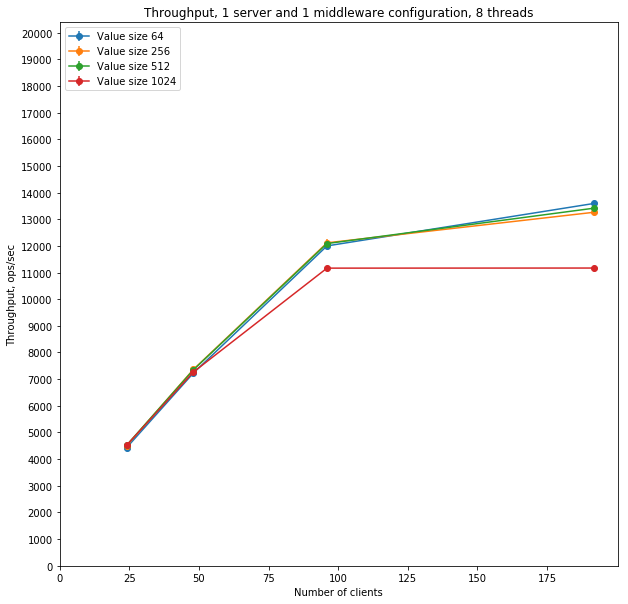

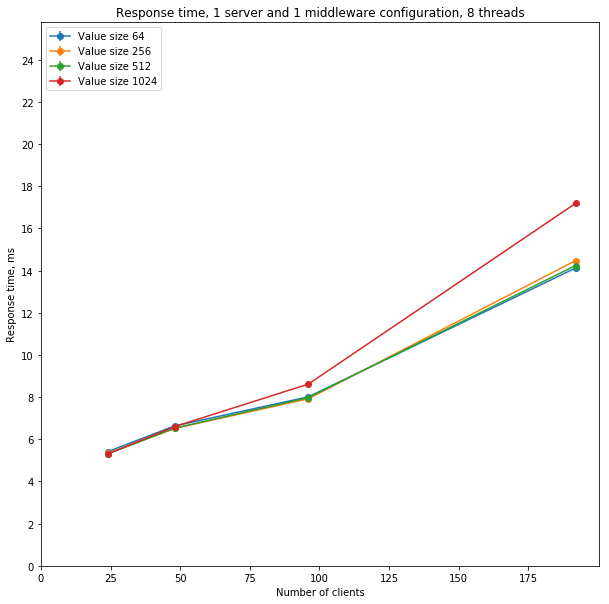

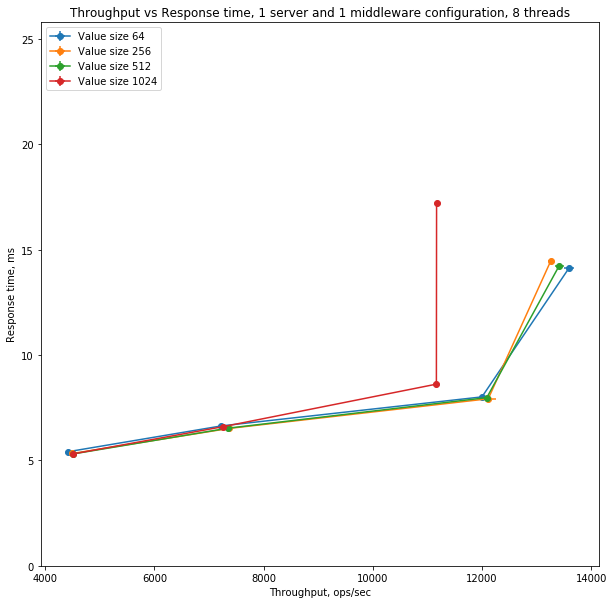

[4428.15, 7228.313333333334, 11997.843333333332, 13592.06]
[5.413488293703742, 6.634764265167534, 8.010247395690786, 14.12077957528681]
[0.006382306885669209, 0.0057890404906766335, -0.008809359465940858, 0.005114512879369926]
0.05088649881099131
0.028655898552567765
0.06365137687079192


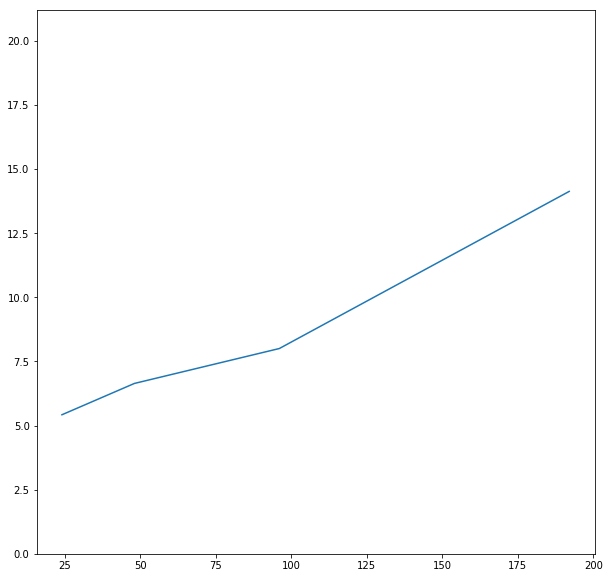

[4500.216666666667, 7363.243333333333, 12113.029999999999, 13260.65]
[5.326809387179897, 6.512916455749689, 7.920636161570624, 14.47332619222616]
[0.00626716839335284, 0.0059500039127886595, 0.00471364768437077, 0.005602065438434778]
0.04942112785707468
0.029327493871269466
0.0682571878193285


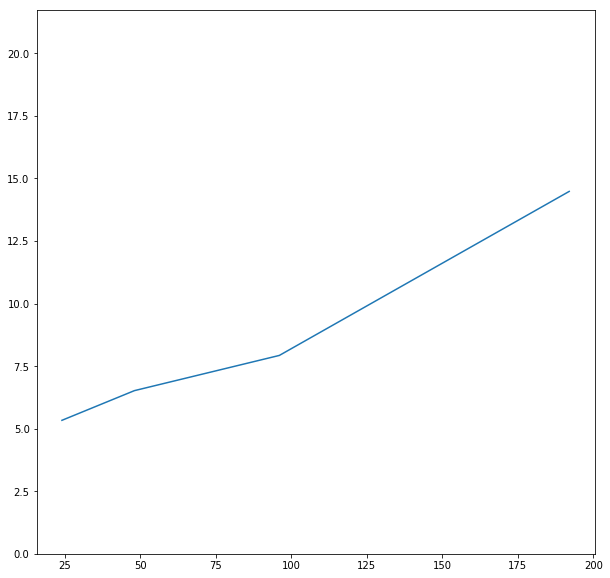

[4517.336666666667, 7348.586666666666, 12086.623333333331, 13414.473333333333]
[5.306287367508085, 6.526095656279684, 7.9753777219778845, 14.23976269412569]
[0.006577661369550292, 0.00577260319515549, -0.032712731728331335, 0.07313615989814792]
0.0508253453654833
0.030193376368712516
0.06525401012653963


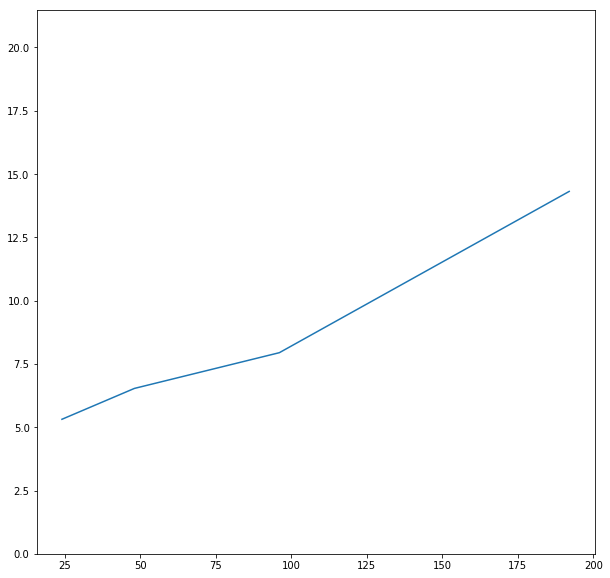

[4515.623333333333, 7265.176666666666, 11164.003333333334, 11167.563333333332]
[5.308677440892528, 6.601039065588132, 8.61485934349607, 17.186664548559826]
[0.006203413504096922, 0.005820230790529735, -0.015793476741581713, 0.005984758107789645]
0.05384840102898351
0.04195458912308203
0.08928963755274745


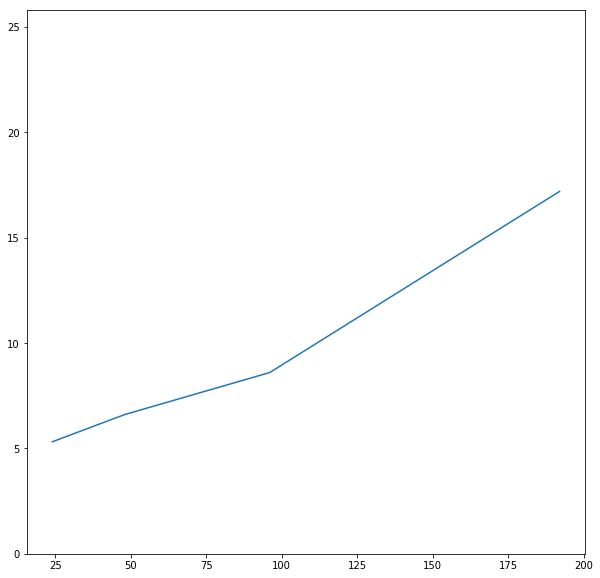

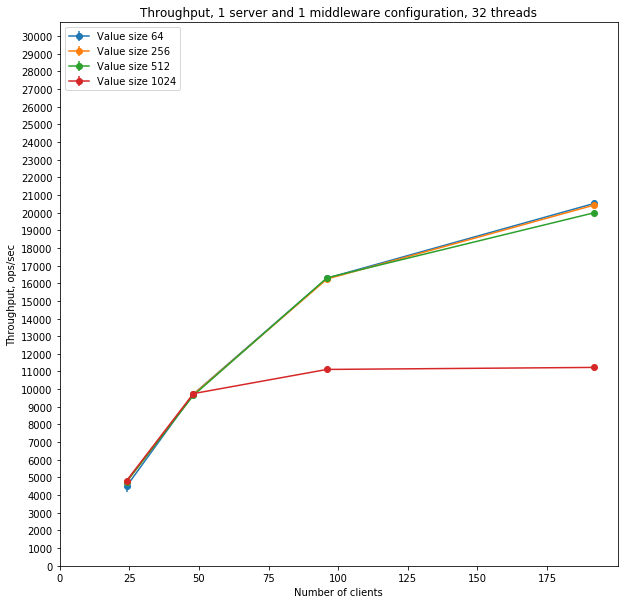

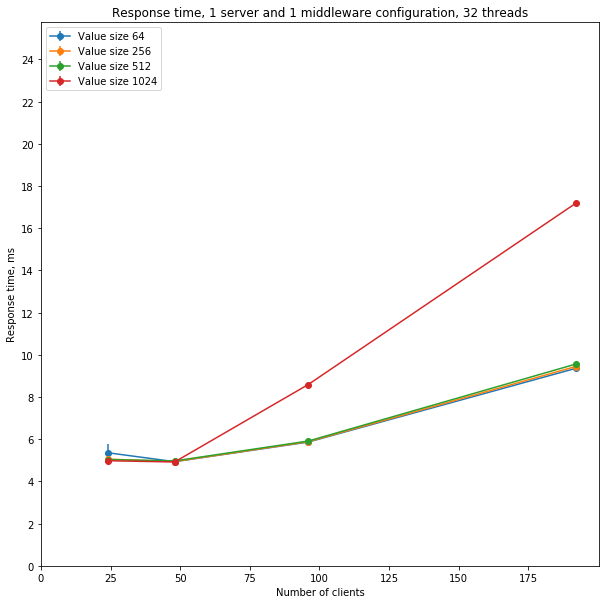

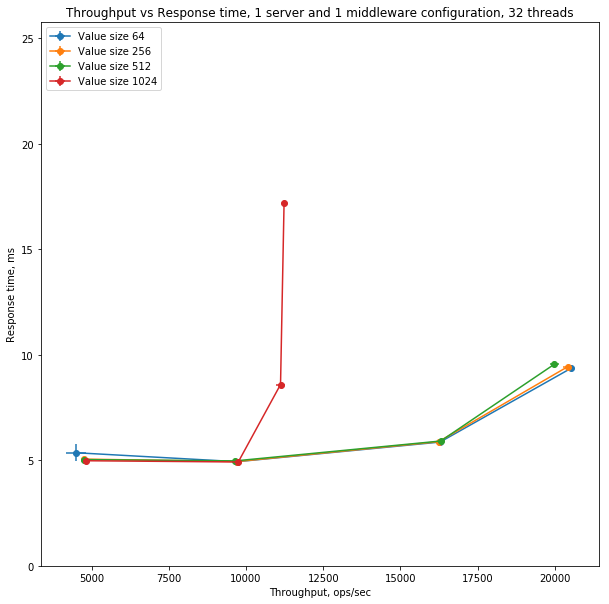

[4498.12, 9718.57, 16282.26, 20516.09]
[5.357175582932931, 4.933881936095456, 5.8634252195093595, 9.35350253629936]
[-0.0216131701916078, 0.005116291009972684, 0.032562192557516134, 0.005005834447699087]
-0.017637235284894803
0.019365485071122995
0.03635497204989583


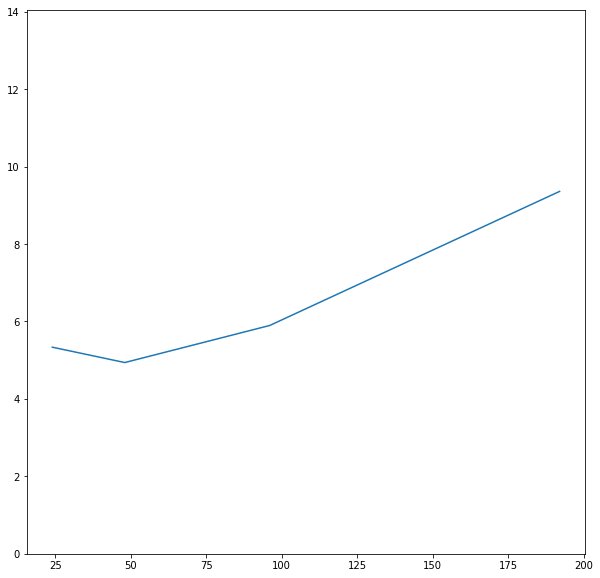

[4741.413333333333, 9704.646666666666, 16234.85, 20423.603333333333]
[5.05563002303224, 4.940472691004601, 5.880322791100404, 9.44149635498221]
[0.006151836666415278, 0.005611555923159983, 0.032882443318145604, -0.040608721866211894]
-0.004798222167818296
0.019580210418662574
0.03709555795710214


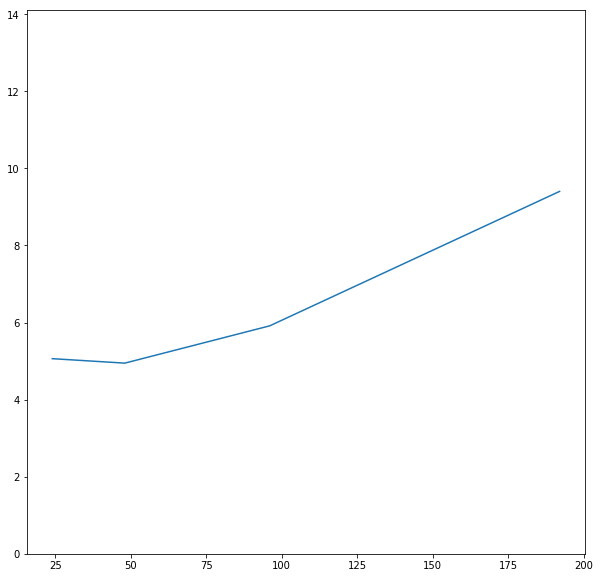

[4762.336666666667, 9645.116666666667, 16301.446666666665, 19987.626666666667]
[5.033069910203587, 4.970927093695473, 5.912425345035693, 9.555614171951854]
[0.006473003254161114, 0.005684559524549826, -0.02337746094196902, 0.05032870470783912]
-0.002589284021171423
0.019614546902921248
0.03794988361371001


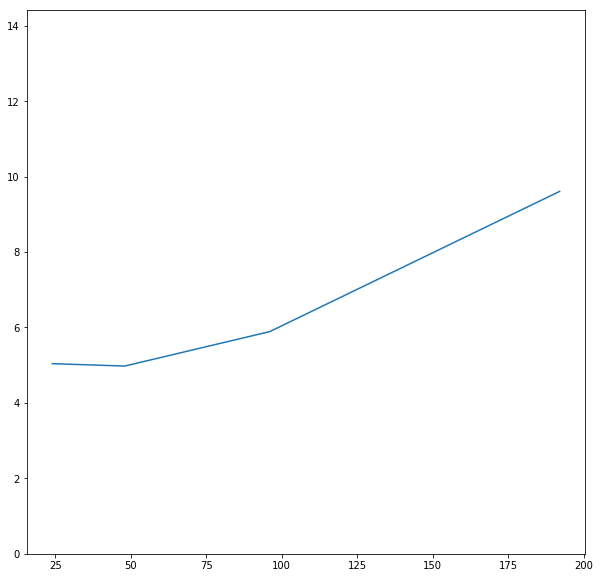

[4815.16, 9748.423333333334, 11116.93, 11231.0]
[4.978396140463435, 4.9196174779702355, 8.590576384163265, 17.172853191316545]
[0.005861911190092606, 0.004255681689429025, 0.04490121621741494, -0.07731405855899709]
-0.002449110937216633
0.07647831054568811
0.08939871674118


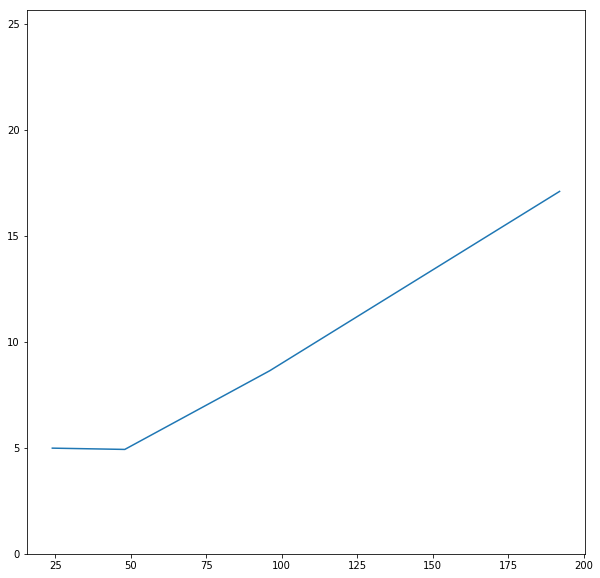

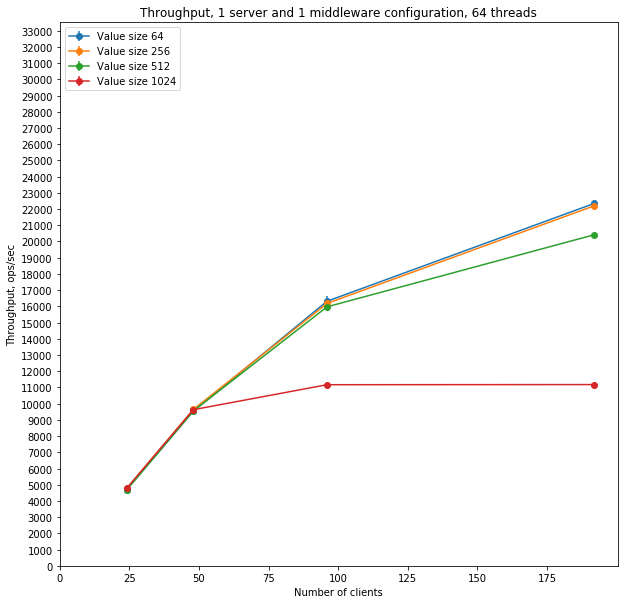

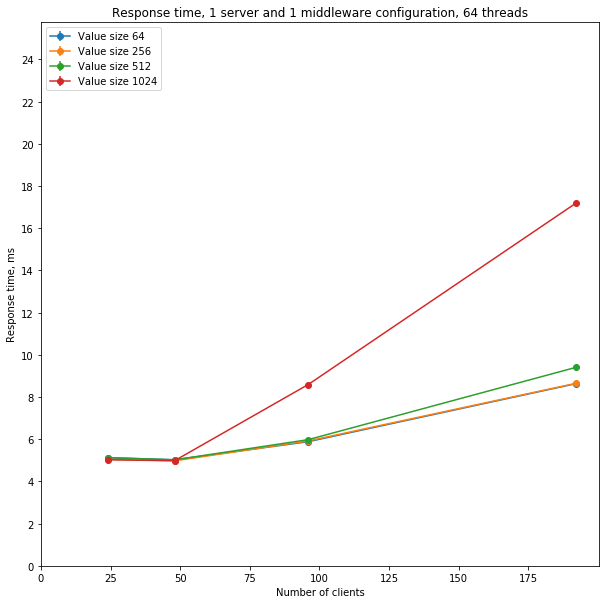

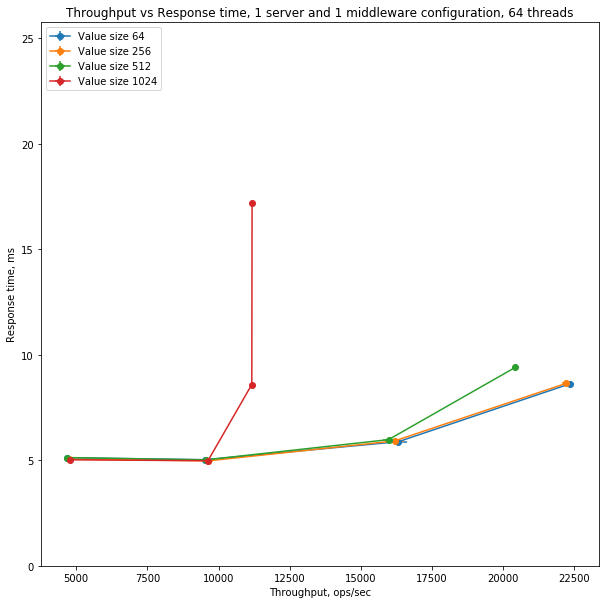

[4682.466666666666, 9539.446666666667, 16313.866666666669, 22348.51]
[5.119269522815043, 5.026522497985675, 5.8811553408155595, 8.627750187173298]
[0.006234129106309716, 0.005215890753853536, 0.0034091196843002436, -0.03657341520952784]
-0.0038644593678903347
0.017804850892289264
0.02861036298289311


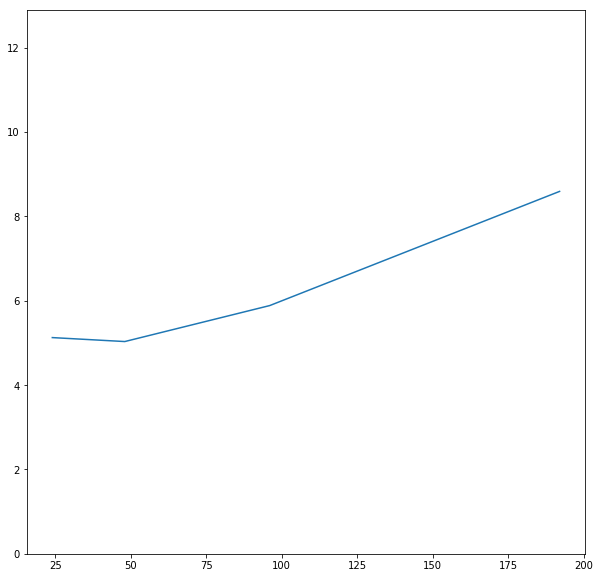

[4743.349999999999, 9642.626666666667, 16179.953333333331, 22201.083333333332]
[5.053168963822382, 4.97369179969277, 5.916760396547133, 8.64337005899803]
[0.006546216377265601, 0.004204955963019508, 0.016507643368928626, 0.004856566579551469]
-0.0033115485054004967
0.01964726243446589
0.028402183983863516


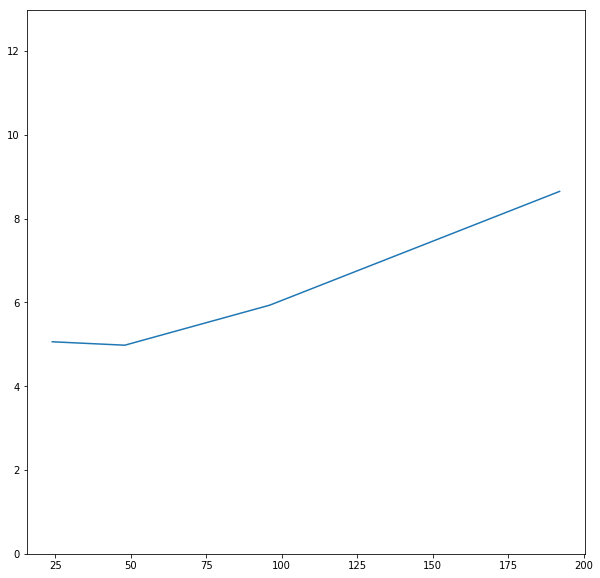

[4673.203333333334, 9549.806666666667, 15969.386666666667, 20416.513333333336]
[5.1289623048707975, 5.021279486370903, 5.978610120884653, 9.39912669619978]
[0.006701240691453947, 0.005000277756955995, 0.03289188628907169, 0.005025563555964396]
-0.004486784104162256
0.019944388219036453
0.0356303809928659


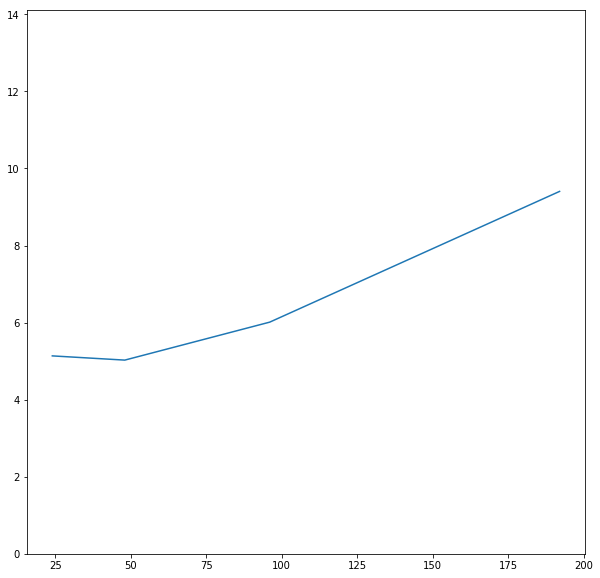

[4771.866666666667, 9627.173333333334, 11166.85, 11176.366666666667]
[5.023129294147208, 4.980660140066168, 8.591487204370823, 17.173954061522398]
[0.006349037183648321, 0.0052270293071883245, 0.005386578298416822, 0.0051530424559373955]
-0.0017695480867100006
0.07522556383968032
0.08940069642866223


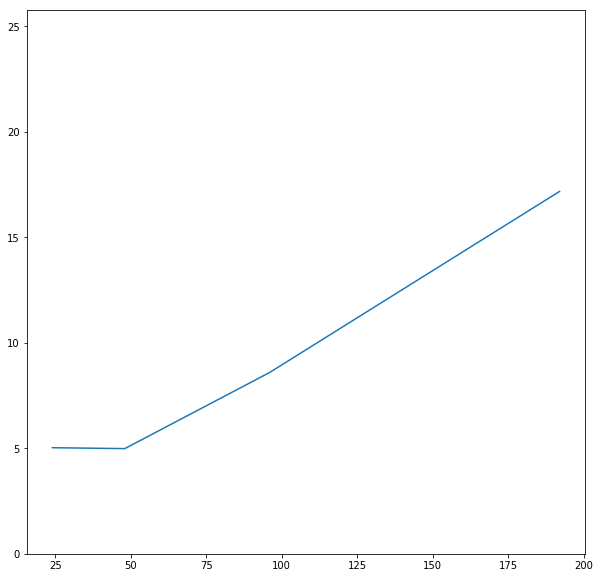

In [3]:
path_to_experiment="/home/skotti/data_from_cloud/long_data/experiment_7/fourth_copy/part5/"
value_sizes=[64, 256, 512, 1024]
client_numbers=[4, 8, 16, 32]
workers = [8, 32, 64]
repetitions = 3
memtier_instances = 6
experiments = len(workers) * len(value_sizes) * len(client_numbers) * repetitions
prefix="/home/skotti/asl-project-2019-ruzhanskaia/report_src/part5_mid_cl_"


import csv
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean 
import re
import numpy as np


clients_data = []

for i in range(memtier_instances):
    initial = open(path_to_experiment+"client"+str(i+1)+".log","r")
    lines = initial.readlines()
    total_ops = 0
    for line in lines:
        if line.startswith("[RUN #1 100%"):
            line = re.sub(' +', ' ', line)
            parts = line.split(' ')
            total_ops = parts[7]
        if line.startswith("Gets"):
            line = re.sub(' +', ' ', line)
            parts = line.split(' ')
            parts = [parts[1], parts[4], total_ops]
            clients_data.append(parts) 
    initial .close()


global_data = pd.DataFrame(columns=['Worker threads', 'Value size', 'Client number', 'Repetition', 'Memtier instance', 'TR', 'RT', 'Total ops'])

j = 0
k = 0
for value_size in value_sizes:
    for w in workers:
        for n in client_numbers:
            for rep in range(repetitions):
                for memtier in range(memtier_instances):
                    d = [w, value_size, n, rep, memtier, clients_data[memtier * experiments + k][0], clients_data[memtier * experiments + k][1], clients_data[memtier * experiments + k][2]]
                    global_data.loc[j] = d
                    j += 1
                k += 1

global_data['Worker threads'] = global_data['Worker threads'].astype(int)
global_data['Value size'] = global_data['Value size'].astype(int)
global_data['Client number'] = global_data['Client number'].astype(int)
global_data['Repetition'] = global_data['Repetition'].astype(int)
global_data['Memtier instance'] = global_data['Memtier instance'].astype(int)
global_data['TR'] = global_data['TR'].astype(float)
global_data['RT'] = global_data['RT'].astype(float)
global_data['Total ops'] = global_data['Total ops'].astype(int)

global_data['Total time'] = global_data['RT']*global_data['Total ops']

TR_graph = []
X_axis =[i * 6 for i in client_numbers]

for w in workers:
    TR_overall = []
    RT_overall = []
    TR_error_overall = []
    RT_error_overall = []
    for value_size in value_sizes:
        TR = []
        RT = []
        TR_error = []
        RT_error = []
        '''for memtier in range(memtier_instances):
            TR_client = []
            RT_client = []
            for client_number in client_numbers:
                subset = global_data[ (global_data['Value size'] == value_size) & 
                                 (global_data['Client number'] == client_number) &
                                 (global_data['Memtier instance'] == memtier)]

                groupped = subset.groupby(["Repetition"]).mean()
                groupped1 = subset.groupby(["Repetition"]).mean()
                TR_client.append(groupped.mean()['TR'])
                RT_client.append(groupped.mean()['RT'])'''

        for client_number in client_numbers:
            subset = global_data[(global_data['Worker threads'] == w) &
                                 (global_data['Value size'] == value_size) & 
                                 (global_data['Client number'] == client_number)]
            groupped = subset.groupby(['Repetition']).sum()
            TR_std = np.std(groupped['TR'].values)
            TR_error.append(TR_std)
            TR.append(float(groupped.mean()['TR']))
            groupped1 = subset.groupby(['Repetition']).sum()
            groupped2 = groupped1['Total time']/groupped1['Total ops']
            RT.append(float(groupped2.mean()))
            RT_std = np.std(groupped2.values)
            RT_error.append(RT_std)
        TR_overall.append(TR)
        RT_overall.append(RT)
        TR_error_overall.append(TR_error)
        RT_error_overall.append(RT_error)

    plt.figure(figsize=(10, 10))
    plt.title("Throughput, 1 server and 1 middleware configuration, "+str(w) + " threads")
    max1 = 0
    for i in range(len(TR_overall)):
        plt.errorbar(X_axis, TR_overall[i],
                yerr=TR_error_overall[i],
                fmt='-o',
                label="Value size "+str(value_sizes[i]))
        max2 = max(TR_overall[i]) + max(TR_overall[i])/2
        if max2 > max1:
            max1 = max2
    plt.ylim(0, max1)
    plt.xticks(np.arange(0, max(X_axis), 25))
    plt.yticks(np.arange(0, max1, 1000))
    plt.ylabel('Throughput, ops/sec')
    plt.xlabel('Number of clients')
    plt.legend(loc="upper left")
    plt.savefig(prefix + str(w)+"_tr.png", dpi=300)
    plt.show()

    max1 = 0
    plt.figure(figsize=(10, 10))
    plt.title("Response time, 1 server and 1 middleware configuration, "+str(w) + " threads")
    for i in range(len(RT_overall)):
        plt.errorbar(X_axis, RT_overall[i],
                yerr=RT_error_overall[i],
                fmt='-o',
                label="Value size "+str(value_sizes[i]))
        max2 = max(RT_overall[i]) + max(RT_overall[i])/2
        if max2 > max1:
            max1 = max2
    plt.ylim(0, max1)
    plt.xticks(np.arange(0, max(X_axis), 25))
    plt.yticks(np.arange(0, max1, 2))
    plt.ylabel('Response time, ms')
    plt.xlabel('Number of clients') 
    plt.legend(loc="upper left")
    plt.savefig(prefix+str(w)+"_rt.png", dpi=300) 
    plt.show()

    max1 = 0
    plt.figure(figsize=(10, 10))
    plt.title("Throughput vs Response time, 1 server and 1 middleware configuration, "+str(w) + " threads")
    for i in range(len(RT_overall)):
        plt.errorbar(TR_overall[i], RT_overall[i],
                xerr=TR_error_overall[i],
                yerr=RT_error_overall[i],
                fmt='-o',
                label="Value size "+str(value_sizes[i]))
        max2 = max(RT_overall[i]) + max(RT_overall[i])/2
        if max2 > max1:
            max1 = max2
    plt.ylim(0, max1)
    plt.ylabel('Response time, ms')
    plt.xlabel('Throughput, ops/sec') 
    plt.legend(loc="upper left")
    plt.savefig(prefix+str(w)+"_rttr.png", dpi=300) 
    plt.show()
    
    for i in range(len(TR_overall)):
        print(TR_overall[i])
        print(RT_overall[i])
        print([(1/t) * 1000 * c - r1 for t, c, r1 in zip(TR_overall[i], X_axis, RT_overall[i])])
        for j in range(len(TR_overall[i]) - 1):
            print((RT_overall[i][j+1]-RT_overall[i][j])/(X_axis[j+1]-X_axis[j]))
        RT_Z = [(1/t) * 1000 * c for t, c in zip(TR_overall[i], X_axis)]
        plt.figure(figsize=(10,10))
        plt.plot(X_axis, RT_Z)
        plt.ylim(0, max(RT_Z) + max(RT_Z)/2)
        plt.show()